In [30]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import itertools
from tqdm import tqdm
import time
import gym
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#from cG_LAGTPKS_Environment import cG_LAGTPKS_Environment
device

device(type='cuda')

In [31]:
pwd

'C:\\Users\\theod\\PycharmProjects\\Machine_Learning\\Project\\pyDRLinWESM\\AYS'

In [28]:

#%cd ../
#%cd Project/pyDRLinWESM/AYS
from AYS_Environment import AYS_Environment

ModuleNotFoundError: No module named 'plots'

In [2]:
def plot(frame_idx, rewards):
    
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [3]:
class network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        
        self.layer = nn.Sequential(nn.Linear(state_dim, hidden_dim), nn.ReLU(), 
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                   )
        
        self.q = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, obs):
        l = self.layer(obs)
        q_values = self.q(l)
        
        return q_values

In [4]:
class Duelling_network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        
        self.layer = nn.Sequential(nn.Linear(state_dim, hidden_dim), nn.ReLU(), 
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                   )
        
        self.a = nn.Linear(hidden_dim, action_dim)
        self.v = nn.Linear(hidden_dim, 1)
        
    def forward(self, obs):
        l = self.layer(obs)
        advantages = self.a(l)
        value = self.v(l)
        
        q_values = value + (advantages - advantages.mean())
        return q_values

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [6]:
class agent:
    def __init__(self, state_dim, action_dim, epsilon=0.1, alpha=0.0025):
        
        self.target_net = self.create_net(state_dim, action_dim).to(device)
        self.policy_net = self.create_net(state_dim, action_dim).to(device)
        
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=alpha)
        self.action_size = action_dim
        self.gamma = 0.96
        self.loss = nn.SmoothL1Loss()
        self.t = 1
        self.epsilon = lambda t: 0.001 + (10-0.01) * np.exp(-0.001* t)
        
    def create_net(self,s_dim, a_dim, duelling=True):
        if duelling:
            net = Duelling_network(s_dim, a_dim)
        else:
            net = network(s_dim, a_dim)
        return net
    
    def get_action(self, state):
        self.t += 1 
        if np.random.uniform() > self.epsilon(self.t):
            with torch.no_grad():
                actions = self.policy_net(torch.Tensor(state).to(device)).cpu().numpy()
            return np.argmax(actions)
        else:
            return torch.tensor(np.random.choice(self.action_size)).numpy()
    
    def update(self, batch_sample):
        
        state, action, reward, next_state, done = batch_sample
        states = torch.Tensor(state).to(device)
        
        actions = torch.tensor(action, dtype=torch.long).unsqueeze(1).to(device)
        
        state_qs = self.policy_net(states).gather(1, actions)
        
        non_final_states = torch.Tensor(next_state).to(device)
        
        next_state_values = self.target_net(non_final_states).max(1)[0].detach()
        next_state_values[done] = 0
        
        expected_qs = next_state_values * self.gamma + torch.Tensor(reward).to(device)
        
        loss = self.loss(state_qs,  expected_qs.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
#         for param in self.policy_net.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(TAU * param + (1 - TAU) * target_param)

In [7]:
BATCH_SIZE = 256
TARGET_UPDATE = 200
MAX_EPISODES = 6000
MAX_STEPS = 10000
TAU = 0.001

In [8]:
env = cG_LAGTPKS_Environment(reward_type='PB')
memory = ReplayBuffer(1000000)
action_dim = 8
state_dim  = 7

Initialized c:GLOBAL environment! 
Reward type: PB 
Planetary Boundaries are: [9.45000000e+02 1.84037318e+04 1.00000000e+06] 
Initial LAGTPKS-values are: [7.58000000e+02 1.85877692e+04 6.00000000e+09] 
Initial derived values are: Wini:18587.769150620836Yini: 148702153204966.7


In [9]:
# env = gym.make('MountainCar-v0')

# memory = ReplayBuffer(1000000)
# action_dim = env.action_space.n
# state_dim  = env.observation_space.shape[0]

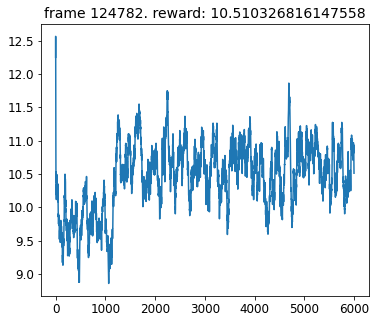

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [30:47<00:00,  3.99it/s]


 ep_length:  19.92

 actions:  [ 3681.  3710. 31979.  3692. 25601.  3661. 25600. 26858.]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [30:47<00:00,  3.25it/s]


In [10]:
dqn = agent(state_dim, action_dim)
rewards = []
mean_rewards = []
frame_idx = 0
ep_len = []
actions = np.zeros(8)

for episodes in tqdm(range(MAX_EPISODES)):
    state = env.reset()
    episode_reward = 0
    
    for steps in range(MAX_STEPS):
        if episodes>1000:
            action = (dqn.get_action(state))
        else:
            action = np.random.choice(action_dim)
            
        next_state, reward, done, = env.step(action)
        
        episode_reward += reward
        
        memory.push(state, action, reward, next_state, done)
        
        state = next_state
        
        frame_idx += 1 
        actions[action] += 1
        
        if memory.__len__() > BATCH_SIZE:
            sample = memory.sample(BATCH_SIZE)
            dqn.update(sample)
        if done:
            break
            
    ep_len.append(steps)       
    rewards.append(episode_reward)
    mean_rewards.append(np.mean(rewards[-50:]))
#     if episodes % TARGET_UPDATE == 0:
#         dqn.target_net.load_state_dict(dqn.policy_net.state_dict()) 
        
    if frame_idx % 100:
        plot(frame_idx, mean_rewards)
        print('\n ep_length: ',np.mean(ep_len[-50:]))
        print('\n actions: ', actions)
        